In [21]:
import torch, os
import torch.nn as nn
import torchvision.datasets as datasets
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import random
import torch.utils.data as torchdata
from torch.utils.data import SubsetRandomSampler
# from train_model import train_model
# from test_model import test_model
%matplotlib inline

In [22]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]='2'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [23]:
filePath = '/local/rcs/ll3504/datasets/256_ObjectCategories/'
namelist = os.listdir(filePath)
nameDic_cal = {}
for name in namelist:
    splits = name.split(".")
    nameDic_cal[int(splits[0])-1] = splits[1]
print(nameDic_cal[1])

american-flag


In [24]:
def get_dataset(path='/database', dataset_name='caltech-256-common'):
    # No holdout testing data. train and test data are the same, but different transformation
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize([256, 256]),
            transforms.RandomCrop(224),
            transforms.RandomRotation(20),
            transforms.RandomHorizontalFlip(0.5),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.Resize([224, 224]),
            transforms.CenterCrop((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    }

    tr_dataset = datasets.ImageFolder(path + dataset_name + '/', data_transforms['train'])
    te_dataset = datasets.ImageFolder(path + dataset_name + '/', data_transforms['test'])
#     print('{} train set size: {}'.format(dataset_name, len(tr_dataset)))
#     print('{} test set size: {}'.format(dataset_name, len(te_dataset)))

    return tr_dataset, te_dataset

In [25]:
def split_dataset(train_dataset, test_dataset, valid_size=0.2, batch_size=128, train_size = 128):
    '''
    This function splits dataset into train, val, and test sets, and return train, val, test dataloaders.
    Val and Test loaders are the same

    '''
    
    # what does the len function gives?
    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    random.shuffle(indices)
    train_idx, valid_idx = indices[split:split+train_size], indices[:split]
#     print("DEBUGGING: train_idx =", train_idx, "valid_idx =", valid_idx)
    
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    
#     print("DEBUGGING: the train_ind are:", len(train_idx))


    train_loader = torchdata.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=48, pin_memory=True, drop_last=True, sampler = train_sampler)
    test_loader = torchdata.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=48, pin_memory=True, drop_last=True, sampler = valid_sampler)
    dataloaders = {'train': train_loader,
                   'val': test_loader,
                   'test': test_loader}
    dataset_sizes ={'train': train_size, #int(np.floor((1-valid_size) * num_train)),
                    'val': int(np.floor(valid_size * num_train)),
                    'test': int(np.floor(valid_size * num_train))}
    return dataloaders, dataset_sizes

In [26]:
imagebase = '/local/rcs/ll3504/datasets/'

In [27]:
corruption = ['zoom_blur', 'speckle_noise', 'spatter',
                       'snow', 'glass_blur', 'motion_blur', 'saturate',
                       'gaussian_blur', 'frost', 'fog', 'brightness', 'contrast',
                       'elastic_transform', 'pixelate', 'jpeg_compression', 'defocus_blur']

# ImageNetC

In [28]:
def get_imagenetc(imagebase, severity=1, batch_size=128, sample_size = 128):
    '''
    Returns:
        ref_dataloaders:          ImageNet original validation data, as a reference
        ref_dataset_sizes:        1000, not the sizes of the real dataset in the ref_loader, probs used downstream
        corrupted_dataloaders:    A list of corrupted dataloaders, each element in a list represetns the data loaders
                                  for one corruption type. Each element contains ['train']['val']['test'] loaders
        corrupted_dataset_sizes:  A list of dictionaries of the sizes of each loaders for each corruption
        corruption:               A list of corruption names, in the same order of the corrupted_dataloaders
    '''
    corruption = ['zoom_blur', 'speckle_noise', 'spatter',
                       'snow', 'glass_blur', 'motion_blur', 'saturate',
                       'gaussian_blur', 'frost', 'fog', 'brightness', 'contrast',
                       'elastic_transform', 'pixelate', 'jpeg_compression', 'defocus_blur']
    corrupted_dataloaders = []
    corrupted_dataset_sizes = []
    
    # this is the imageNet validation data
    imagenet_val = datasets.ImageNet(imagebase+'imagenetc/', split='val', transform=transforms.Compose([
            transforms.Resize([224, 224]),
            transforms.CenterCrop((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]),
                                   target_transform=None)#, download=False)
    
    # TODO: subsample some size of ImageNet training data as source
        # Doesn't need this step
#     print("DEBUGGING: imagenet_val size is:", len(imagenet_val))
    
    random_indices = random.sample(range(0, len(imagenet_val)), int(len(imagenet_val)*0.02))
#     print("DEBUGGING: random indices are:", len(random_indices))
    imagenet_val_subset = data.Subset(imagenet_val, random_indices)
    val_loader = torch.utils.data.DataLoader(imagenet_val_subset,
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=48)
    ref_dataloaders = { 'val': val_loader,
                       'test': val_loader}
    ref_dataset_sizes ={'val': int(len(val_loader.dataset)),
                        'test': int(len(val_loader.dataset))}
    
    # for every type of corruption, go to the specified severity folder
    for corr in corruption:
        dataset_name = 'imagenetc/' + corr + '/' + str(severity)
        # Get dataset from folder
        corr_trian_images, corr_test_images = get_dataset(imagebase, dataset_name)
        # get corruption-specific train, val, test loader
        # train: training data, non-overlap with val/test
        # val: non-overlap with train, same as test
        # test: non-overlap with train, same as test
        corr_dataloaders, corr_dataset_sizes = split_dataset(corr_trian_images, corr_test_images, valid_size=0.02, batch_size=batch_size, train_size=sample_size)
        corrupted_dataloaders.append(corr_dataloaders)
        corrupted_dataset_sizes.append(corr_dataset_sizes)
    return ref_dataloaders, ref_dataset_sizes, corrupted_dataloaders, corrupted_dataset_sizes, corruption

In [45]:
ref_dataloaders, ref_dataset_sizes, corrupted_dataloaders, corrupted_dataset_sizes, corruption \
= get_imagenetc(imagebase, 5, 32, 64)



In [46]:
# in total 16 corruptions, each have 3 dataloaders ['train']['val']['test']
len(corrupted_dataloaders[15]['val']) # why is this 31??

31

In [33]:
corrupted_dataset_sizes[0]

{'train': 64, 'val': 1000, 'test': 1000}

In [45]:
ref_dataset_sizes['val']

1000

In [59]:
len(ref_dataloaders['val'])

32

# Vanila Resnet-50 Baseline

Test top-1 accuracy for all corruptions, for different batch sizes, average accuracy over batches, (inference time)
on reference data (IM-val) and corruption test data


In [30]:
import time

In [31]:
batchsizes = [32, 64, 128, 256, 512, 1000]
severity = [1,2,3,4,5]
# a dictionary that maps 'coruption_type' to a table of 5x6, 
# recording the performance of all corruption for all batchsizes
# baseline_performances = {}

# # in addition to all the corruptions, save performance for reference (IM-val) too
# baseline_performances['ref'] = np.zeros(shape=(len(severity), len(batchsizes)))
# for c in corruption:
#     baseline_performances[c] = np.zeros(shape=(len(severity), len(batchsizes)))

baseline_performances = np.zeros(shape=(len(corruption), len(severity), len(batchsizes)))
baseline_inf_times = np.zeros(shape=(len(corruption), len(severity), len(batchsizes)))



In [32]:
model = models.resnet50(pretrained=True)
model.eval()
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [33]:
for severity_ind in range(len(severity)):
    for bs_ind in range(len(batchsizes)):
        ref_dataloaders, ref_dataset_sizes, corrupted_dataloaders, corrupted_dataset_sizes, corruption \
        = get_imagenetc(imagebase, severity[severity_ind], batchsizes[bs_ind])
        for cor_ind in range(len(corrupted_dataloaders)):
            with torch.no_grad():
                # TOOD: also record average batch inference time.
                batch_accs = []
                batch_inf_times = []
                for data in corrupted_dataloaders[cor_ind]['test']:
                    start = time.time()
                    images, labels = data[0].to(device), data[1].to(device)
                    outputs = model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    inference_time = time.time() - start
                    batch_inf_times.append(inference_time)
                    batch_accuracy = ((predicted == labels).sum().item()) / labels.size(0)
                    batch_accs.append(batch_accuracy)
            print(f'Vanilla resnet50 on 1000 test images of corruption {corruption[cor_ind]} with severity {severity[severity_ind]} and batch_size {batchsizes[bs_ind]}, average batch_size = {np.mean(batch_accs)}')
            baseline_performances[cor_ind, severity_ind, bs_ind] = np.mean(batch_accs)
            print(f'Average Inference time = {np.mean(batch_inf_times)}')
            baseline_inf_times[cor_ind, severity_ind, bs_ind] = np.mean(batch_inf_times)
            
        with open('ResNet50_performances.npy', 'wb') as f:
            np.save(f, baseline_performances)
        with open('ResNet50_times.npy', 'wb') as f:
            np.save(f, baseline_inf_times)
        
            
            
            

Vanilla resnet50 on 1000 test images of corruption zoom_blur with severity 1 and batch_size 32, average batch_size = 0.5211693548387096
Average Inference time = 0.012341353201097058
Vanilla resnet50 on 1000 test images of corruption speckle_noise with severity 1 and batch_size 32, average batch_size = 0.6118951612903226
Average Inference time = 0.007740851371519027
Vanilla resnet50 on 1000 test images of corruption spatter with severity 1 and batch_size 32, average batch_size = 0.7258064516129032
Average Inference time = 0.009073249755367156
Vanilla resnet50 on 1000 test images of corruption snow with severity 1 and batch_size 32, average batch_size = 0.5594758064516129
Average Inference time = 0.007492019284156061
Vanilla resnet50 on 1000 test images of corruption glass_blur with severity 1 and batch_size 32, average batch_size = 0.563508064516129
Average Inference time = 0.007989298912786668
Vanilla resnet50 on 1000 test images of corruption motion_blur with severity 1 and batch_size

Vanilla resnet50 on 1000 test images of corruption jpeg_compression with severity 1 and batch_size 128, average batch_size = 0.65625
Average Inference time = 0.01485889298575265
Vanilla resnet50 on 1000 test images of corruption defocus_blur with severity 1 and batch_size 128, average batch_size = 0.6127232142857143
Average Inference time = 0.014368431908743722
Vanilla resnet50 on 1000 test images of corruption zoom_blur with severity 1 and batch_size 256, average batch_size = 0.5403645833333334
Average Inference time = 0.022817214330037434
Vanilla resnet50 on 1000 test images of corruption speckle_noise with severity 1 and batch_size 256, average batch_size = 0.6015625
Average Inference time = 0.020807266235351562
Vanilla resnet50 on 1000 test images of corruption spatter with severity 1 and batch_size 256, average batch_size = 0.7291666666666666
Average Inference time = 0.025409777959187824
Vanilla resnet50 on 1000 test images of corruption snow with severity 1 and batch_size 256, av

Vanilla resnet50 on 1000 test images of corruption pixelate with severity 1 and batch_size 1000, average batch_size = 0.636
Average Inference time = 0.06142139434814453
Vanilla resnet50 on 1000 test images of corruption jpeg_compression with severity 1 and batch_size 1000, average batch_size = 0.657
Average Inference time = 0.061022043228149414
Vanilla resnet50 on 1000 test images of corruption defocus_blur with severity 1 and batch_size 1000, average batch_size = 0.561
Average Inference time = 0.07242608070373535
Vanilla resnet50 on 1000 test images of corruption zoom_blur with severity 2 and batch_size 32, average batch_size = 0.44556451612903225
Average Inference time = 0.008818595640120967
Vanilla resnet50 on 1000 test images of corruption speckle_noise with severity 2 and batch_size 32, average batch_size = 0.5604838709677419
Average Inference time = 0.007466093186409243
Vanilla resnet50 on 1000 test images of corruption spatter with severity 2 and batch_size 32, average batch_siz

Vanilla resnet50 on 1000 test images of corruption contrast with severity 2 and batch_size 128, average batch_size = 0.5658482142857143
Average Inference time = 0.013641834259033203
Vanilla resnet50 on 1000 test images of corruption elastic_transform with severity 2 and batch_size 128, average batch_size = 0.44419642857142855
Average Inference time = 0.014738116945539202
Vanilla resnet50 on 1000 test images of corruption pixelate with severity 2 and batch_size 128, average batch_size = 0.6361607142857143
Average Inference time = 0.015449081148420061
Vanilla resnet50 on 1000 test images of corruption jpeg_compression with severity 2 and batch_size 128, average batch_size = 0.6138392857142857
Average Inference time = 0.015651464462280273
Vanilla resnet50 on 1000 test images of corruption defocus_blur with severity 2 and batch_size 128, average batch_size = 0.53125
Average Inference time = 0.016489437648228238
Vanilla resnet50 on 1000 test images of corruption zoom_blur with severity 2 an

Vanilla resnet50 on 1000 test images of corruption brightness with severity 2 and batch_size 1000, average batch_size = 0.754
Average Inference time = 0.06440281867980957
Vanilla resnet50 on 1000 test images of corruption contrast with severity 2 and batch_size 1000, average batch_size = 0.594
Average Inference time = 0.06136369705200195
Vanilla resnet50 on 1000 test images of corruption elastic_transform with severity 2 and batch_size 1000, average batch_size = 0.416
Average Inference time = 0.06226301193237305
Vanilla resnet50 on 1000 test images of corruption pixelate with severity 2 and batch_size 1000, average batch_size = 0.637
Average Inference time = 0.06618237495422363
Vanilla resnet50 on 1000 test images of corruption jpeg_compression with severity 2 and batch_size 1000, average batch_size = 0.641
Average Inference time = 0.06573033332824707
Vanilla resnet50 on 1000 test images of corruption defocus_blur with severity 2 and batch_size 1000, average batch_size = 0.491
Average 

Vanilla resnet50 on 1000 test images of corruption frost with severity 3 and batch_size 128, average batch_size = 0.3236607142857143
Average Inference time = 0.01393542970929827
Vanilla resnet50 on 1000 test images of corruption fog with severity 3 and batch_size 128, average batch_size = 0.4810267857142857
Average Inference time = 0.01577394349234445
Vanilla resnet50 on 1000 test images of corruption brightness with severity 3 and batch_size 128, average batch_size = 0.6863839285714286
Average Inference time = 0.01646566390991211
Vanilla resnet50 on 1000 test images of corruption contrast with severity 3 and batch_size 128, average batch_size = 0.4497767857142857
Average Inference time = 0.014751740864345006
Vanilla resnet50 on 1000 test images of corruption elastic_transform with severity 3 and batch_size 128, average batch_size = 0.5368303571428571
Average Inference time = 0.01699389730181013
Vanilla resnet50 on 1000 test images of corruption pixelate with severity 3 and batch_size 

Vanilla resnet50 on 1000 test images of corruption saturate with severity 3 and batch_size 1000, average batch_size = 0.707
Average Inference time = 0.06552410125732422
Vanilla resnet50 on 1000 test images of corruption gaussian_blur with severity 3 and batch_size 1000, average batch_size = 0.424
Average Inference time = 0.059473514556884766
Vanilla resnet50 on 1000 test images of corruption frost with severity 3 and batch_size 1000, average batch_size = 0.301
Average Inference time = 0.07430672645568848
Vanilla resnet50 on 1000 test images of corruption fog with severity 3 and batch_size 1000, average batch_size = 0.486
Average Inference time = 0.06009864807128906
Vanilla resnet50 on 1000 test images of corruption brightness with severity 3 and batch_size 1000, average batch_size = 0.71
Average Inference time = 0.05917525291442871
Vanilla resnet50 on 1000 test images of corruption contrast with severity 3 and batch_size 1000, average batch_size = 0.454
Average Inference time = 0.06551

Vanilla resnet50 on 1000 test images of corruption motion_blur with severity 4 and batch_size 128, average batch_size = 0.21428571428571427
Average Inference time = 0.01525252205984933
Vanilla resnet50 on 1000 test images of corruption saturate with severity 4 and batch_size 128, average batch_size = 0.5736607142857143
Average Inference time = 0.015155962535313197
Vanilla resnet50 on 1000 test images of corruption gaussian_blur with severity 4 and batch_size 128, average batch_size = 0.29910714285714285
Average Inference time = 0.016593899045671736
Vanilla resnet50 on 1000 test images of corruption frost with severity 4 and batch_size 128, average batch_size = 0.28794642857142855
Average Inference time = 0.013709102358136858
Vanilla resnet50 on 1000 test images of corruption fog with severity 4 and batch_size 128, average batch_size = 0.38950892857142855
Average Inference time = 0.015479769025530134
Vanilla resnet50 on 1000 test images of corruption brightness with severity 4 and batch

Vanilla resnet50 on 1000 test images of corruption glass_blur with severity 4 and batch_size 1000, average batch_size = 0.131
Average Inference time = 0.06569957733154297
Vanilla resnet50 on 1000 test images of corruption motion_blur with severity 4 and batch_size 1000, average batch_size = 0.218
Average Inference time = 0.06638956069946289
Vanilla resnet50 on 1000 test images of corruption saturate with severity 4 and batch_size 1000, average batch_size = 0.608
Average Inference time = 0.06410503387451172
Vanilla resnet50 on 1000 test images of corruption gaussian_blur with severity 4 and batch_size 1000, average batch_size = 0.271
Average Inference time = 0.06606173515319824
Vanilla resnet50 on 1000 test images of corruption frost with severity 4 and batch_size 1000, average batch_size = 0.289
Average Inference time = 0.06788921356201172
Vanilla resnet50 on 1000 test images of corruption fog with severity 4 and batch_size 1000, average batch_size = 0.398
Average Inference time = 0.06

Vanilla resnet50 on 1000 test images of corruption spatter with severity 5 and batch_size 128, average batch_size = 0.28125
Average Inference time = 0.014622824532645089
Vanilla resnet50 on 1000 test images of corruption snow with severity 5 and batch_size 128, average batch_size = 0.16852678571428573
Average Inference time = 0.013402972902570452
Vanilla resnet50 on 1000 test images of corruption glass_blur with severity 5 and batch_size 128, average batch_size = 0.10602678571428571
Average Inference time = 0.015281881604875838
Vanilla resnet50 on 1000 test images of corruption motion_blur with severity 5 and batch_size 128, average batch_size = 0.14620535714285715
Average Inference time = 0.015257324491228377
Vanilla resnet50 on 1000 test images of corruption saturate with severity 5 and batch_size 128, average batch_size = 0.4654017857142857
Average Inference time = 0.015106303351266044
Vanilla resnet50 on 1000 test images of corruption gaussian_blur with severity 5 and batch_size 12

Vanilla resnet50 on 1000 test images of corruption zoom_blur with severity 5 and batch_size 1000, average batch_size = 0.234
Average Inference time = 0.05799722671508789
Vanilla resnet50 on 1000 test images of corruption speckle_noise with severity 5 and batch_size 1000, average batch_size = 0.126
Average Inference time = 0.05722784996032715
Vanilla resnet50 on 1000 test images of corruption spatter with severity 5 and batch_size 1000, average batch_size = 0.232
Average Inference time = 0.05708909034729004
Vanilla resnet50 on 1000 test images of corruption snow with severity 5 and batch_size 1000, average batch_size = 0.186
Average Inference time = 0.057125091552734375
Vanilla resnet50 on 1000 test images of corruption glass_blur with severity 5 and batch_size 1000, average batch_size = 0.102
Average Inference time = 0.056966304779052734
Vanilla resnet50 on 1000 test images of corruption motion_blur with severity 5 and batch_size 1000, average batch_size = 0.145
Average Inference time 

In [37]:
# baseline_performances
baseline_inf_times

array([[[0.01234135, 0.01001948, 0.01468137, 0.02281721, 0.04562116,
         0.08803892],
        [0.0088186 , 0.01091402, 0.01428223, 0.02129634, 0.04893327,
         0.0764935 ],
        [0.00788284, 0.00971629, 0.01723082, 0.02119001, 0.03545141,
         0.06318855],
        [0.00824139, 0.00917166, 0.01565259, 0.02314011, 0.03567672,
         0.0659821 ],
        [0.00963173, 0.01067182, 0.01384721, 0.02318716, 0.03431106,
         0.05799723]],

       [[0.00774085, 0.01111949, 0.01689666, 0.02080727, 0.04376912,
         0.0622201 ],
        [0.00746609, 0.01131264, 0.01371367, 0.02095318, 0.0349977 ,
         0.06262851],
        [0.00941182, 0.01167882, 0.01513331, 0.02667912, 0.03465748,
         0.06112051],
        [0.00908162, 0.00942419, 0.01486727, 0.02103329, 0.03460431,
         0.06559706],
        [0.00955881, 0.0122063 , 0.0132088 , 0.02220949, 0.03469157,
         0.05722785]],

       [[0.00907325, 0.01112515, 0.01606311, 0.02540978, 0.03573251,
         0.058188

In [27]:
with open('ResNet50_performances.npy', 'wb') as f:
    np.save(f, baseline_performances)
with open('ResNet50_times.npy', 'wb') as f:
    np.save(f, baseline_inf_times)

In [31]:
with open('ResNet50_performances.npy', 'rb') as f:
    baseline_performances = np.load(f)
with open('ResNet50_times.npy', 'rb') as f:
    baseline_inf_times = np.load(f)


In [13]:
baseline_inf_times

array([[[0.01234135, 0.01001948, 0.01468137, 0.02281721, 0.04562116,
         0.08803892],
        [0.0088186 , 0.01091402, 0.01428223, 0.02129634, 0.04893327,
         0.0764935 ],
        [0.00788284, 0.00971629, 0.01723082, 0.02119001, 0.03545141,
         0.06318855],
        [0.00824139, 0.00917166, 0.01565259, 0.02314011, 0.03567672,
         0.0659821 ],
        [0.00963173, 0.01067182, 0.01384721, 0.02318716, 0.03431106,
         0.05799723]],

       [[0.00774085, 0.01111949, 0.01689666, 0.02080727, 0.04376912,
         0.0622201 ],
        [0.00746609, 0.01131264, 0.01371367, 0.02095318, 0.0349977 ,
         0.06262851],
        [0.00941182, 0.01167882, 0.01513331, 0.02667912, 0.03465748,
         0.06112051],
        [0.00908162, 0.00942419, 0.01486727, 0.02103329, 0.03460431,
         0.06559706],
        [0.00955881, 0.0122063 , 0.0132088 , 0.02220949, 0.03469157,
         0.05722785]],

       [[0.00907325, 0.01112515, 0.01606311, 0.02540978, 0.03573251,
         0.058188

## Graphing the performance

# TTA - Robust Pseudo label

In [29]:
import time

In [30]:
import torch
from torchvision import models, datasets, transforms

def gce(logits, target, q = 0.8):
    """ Generalized cross entropy.
    
    Reference: https://arxiv.org/abs/1805.07836
    """
    probs = torch.nn.functional.softmax(logits, dim=1)
    probs_with_correct_idx = probs.index_select(-1, target).diag()
    loss = (1. - probs_with_correct_idx**q) / q
    return loss.mean()

def adapt_batchnorm(model):
    model.eval()
    parameters = []
    for module in model.modules():
        if isinstance(module, torch.nn.BatchNorm2d):
            parameters.extend(module.parameters())
            module.train()
    return parameters


# ---



In [34]:
def adapt(
#         datadir = '/data/imagenetc/gaussian_blur/3',
        baseline,
        model,
        dataloader,
        num_epochs = 5, # followed their best epochs in the paper
        batch_size = 32,
        learning_rate = 1e-3,
        gce_q = 0.8,
    ):
    
#     model = models.resnet50(pretrained = True).to(device)
    parameters = adapt_batchnorm(model)
#     # TODO change this loader
#     val_loader = get_dataset_loader(
#         datadir,
#         batch_size = batch_size,
#         shuffle = True
#     )
    optimizer = torch.optim.SGD(
#         model.parameters(), lr = learning_rate
        parameters, lr = learning_rate
    )
    
    b_correct, num_correct, num_samples = 0., 0., 0.
    for epoch in range(num_epochs):
        predictions = []
#         batch_inf_times = []
        batch_accs = []
        for images, labels in dataloader:
#             start = time.time()
            
            outputs = model(images.to(device))
            predictions = outputs.argmax(dim = 1)
#             _, predicted = torch.max(outputs.data, 1)

#             inference_time = time.time() - start
#             batch_inf_times.append(inference_time)
           
#             batch_accuracy = ((predicted == labels).sum().item()) / labels.size(0)
#             batch_accs.append(batch_accuracy)
            
            # TODO: in our scenario, do we want to revert back to original model after adapting in each step?
            loss = gce(outputs, predictions, q = gce_q)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            b_outputs = baseline(images.to(device))
            b_predictions = b_outputs.argmax(dim = 1)

            num_correct += (predictions.detach().cpu() == labels).float().sum()
            b_correct += (b_predictions.detach().cpu() == labels).float().sum()

            num_samples += len(labels)

            print(f"Baseline Correct: {b_correct:#5.0f}/{num_samples:#5.0f} ({100 * b_correct / num_samples:.2f} %)")
            print(f"Adapt Correct: {num_correct:#5.0f}/{num_samples:#5.0f} ({100 * num_correct / num_samples:.2f} %)")
    
    return model, num_correct/num_samples, b_correct/num_samples
                    


In [35]:
target_sizes = [32, 64, 128, 256, 512]
severity = [1,2,3,4,5]

rpl_corrupt_train_acc = np.zeros(shape=(len(corruption), len(severity), len(target_sizes)))
rpl_corrupt_val_acc = np.zeros(shape=(len(corruption), len(severity), len(target_sizes)))
rpl_ref_acc = np.zeros(shape=(len(corruption), len(severity), len(target_sizes)))


# rpl_adpt_times = np.zeros(shape=(len(corruption), len(severity), len(target_sizes)))
baseline_train_acc = np.zeros(shape=(len(corruption), len(severity), len(target_sizes)))
baseline_val_acc = np.zeros(shape=(len(corruption), len(severity), len(target_sizes)))
baseline_ref_acc = np.zeros(shape=(len(corruption), len(severity), len(target_sizes)))





In [36]:
baseline = models.resnet50(pretrained=True)
baseline.to(device)
for severity_ind in range(len(severity)):
    for ts_ind in range(len(target_sizes)):
        ref_dataloaders, ref_dataset_sizes, corrupted_dataloaders, corrupted_dataset_sizes, corruption \
        = get_imagenetc(imagebase, severity[severity_ind], 32, target_sizes[ts_ind])
        
        # TODO: wait, shouldn't I use a new model for every corruption?
        # uh bug!
#         model = models.resnet50(pretrained=True)
#         model.to(device)

        # adapt the model using the rpl methods
        # evaluate the adapted model on the test corrupted (target) dataset & the reference (source) dataset
        for cor_ind in range(len(corrupted_dataloaders)):
            
            print(f'## Experiment: Severity = {severity[severity_ind]}, target_size = {target_sizes[ts_ind]}, corruption = {corruption[cor_ind]}')
            model = models.resnet50(pretrained=True)
            model.to(device)
            
            # adapt the model
#             start = time.time()
            model, train_acc, base_acc = adapt(baseline, model, corrupted_dataloaders[cor_ind]['train'])
#             adapt_time = time.time() - start
#             print(f"Adaptation time: {adapt_time}")
            
#             rpl_adpt_times[cor_ind, severity_ind, ts_ind] = adapt_time
            rpl_corrupt_train_acc[cor_ind, severity_ind, ts_ind] = train_acc
            baseline_train_acc[cor_ind, severity_ind, ts_ind] = base_acc
            
            # evaluate both the adapted model & baseline model on the, corrupted val data, and reference (soure) data
            with torch.no_grad():
                base_val_correct, crpt_val_correct, crpt_val_samples, base_ref_correct, ref_correct, ref_samples = 0, 0, 0, 0, 0, 0
                for images, labels in corrupted_dataloaders[cor_ind]['val']:
                    labels = labels.to(device)
                    outputs = model(images.to(device))
                    _, predicted = torch.max(outputs.data, 1)
                    crpt_val_correct += (predicted == labels).sum().item()
                    crpt_val_samples += len(labels)
                    
                    b_outputs = baseline(images.to(device))
                    _, b_predicted = torch.max(b_outputs.data, 1)
                    base_val_correct += (b_predicted == labels).sum().item()
                    
                    
                print(f"Corrupt Val Adapt Accuracy: {crpt_val_correct:#5.0f}/{crpt_val_samples:#5.0f} ({crpt_val_correct / crpt_val_samples})")
                print(f"Corrupt Val Base Accuracy: {base_val_correct:#5.0f}/{crpt_val_samples:#5.0f} ({base_val_correct / crpt_val_samples})")
                
                rpl_corrupt_val_acc[cor_ind, severity_ind, ts_ind] = crpt_val_correct / crpt_val_samples
                baseline_val_acc[cor_ind, severity_ind, ts_ind] = base_val_correct / crpt_val_samples
                

                for images, labels in ref_dataloaders['val']:
                    labels = labels.to(device)
                    outputs = model(images.to(device))
                    _, predicted = torch.max(outputs.data, 1)
                    ref_correct += (predicted == labels).sum().item()
                    ref_samples += len(labels)
                    
                    b_outputs = baseline(images.to(device))
                    _, b_predicted = torch.max(b_outputs.data, 1)
                    base_ref_correct += (b_predicted == labels).sum().item()
                    
                print(f"Ref Adapt Accuracy: {ref_correct:#5.0f}/{ref_samples:#5.0f} ({ref_correct / ref_samples})")
                print(f"Ref Base Accuracy: {base_ref_correct:#5.0f}/{ref_samples:#5.0f} ({base_ref_correct / ref_samples})")
                
                rpl_ref_acc[cor_ind, severity_ind, ts_ind] = ref_correct / ref_samples
                baseline_ref_acc[cor_ind, severity_ind, ts_ind] = base_ref_correct / ref_samples


        with open('RPL_corrupt_train_acc_2.npy', 'wb') as f:
            np.save(f, rpl_corrupt_train_acc)
        with open('RPL_corrupt_validation_acc_2.npy', 'wb') as f:
            np.save(f, rpl_corrupt_val_acc)
        with open('RPL_source_acc_2.npy', 'wb') as f:
            np.save(f, rpl_ref_acc)
            
        with open('Base_corrupt_train_acc_2.npy', 'wb') as f:
            np.save(f, baseline_train_acc)
        with open('Base_corrupt_validation_acc_2.npy', 'wb') as f:
            np.save(f, baseline_val_acc)
        with open('Base_source_acc_2.npy', 'wb') as f:
            np.save(f, baseline_ref_acc)
#         with open('RPL_adapt_time.npy', 'wb') as f:
#             np.save(f, rpl_adpt_times)
        
        
            
            
            

## Experiment: Severity = 1, target_size = 32, corruption = zoom_blur
Baseline Correct:   17./  32. (53.12 %)
Adapt Correct:   17./  32. (53.12 %)
Corrupt Val Adapt Accuracy:  585./ 992. (0.5897177419354839)
Corrupt Val Base Accuracy:  584./ 992. (0.5887096774193549)
Ref Adapt Accuracy:  742./1000. (0.742)
Ref Base Accuracy:  742./1000. (0.742)
## Experiment: Severity = 1, target_size = 32, corruption = speckle_noise
Baseline Correct:   15./  32. (46.88 %)
Adapt Correct:   15./  32. (46.88 %)
Corrupt Val Adapt Accuracy:  616./ 992. (0.6209677419354839)
Corrupt Val Base Accuracy:  617./ 992. (0.6219758064516129)
Ref Adapt Accuracy:  741./1000. (0.741)
Ref Base Accuracy:  741./1000. (0.741)
## Experiment: Severity = 1, target_size = 32, corruption = spatter
Baseline Correct:   16./  32. (50.00 %)
Adapt Correct:   16./  32. (50.00 %)
Corrupt Val Adapt Accuracy:  715./ 992. (0.7207661290322581)
Corrupt Val Base Accuracy:  715./ 992. (0.7207661290322581)
Ref Adapt Accuracy:  740./1000. (0.7

Corrupt Val Adapt Accuracy:  698./ 992. (0.7036290322580645)
Corrupt Val Base Accuracy:  698./ 992. (0.7036290322580645)
Ref Adapt Accuracy:  738./1000. (0.738)
Ref Base Accuracy:  738./1000. (0.738)
## Experiment: Severity = 1, target_size = 64, corruption = gaussian_blur
Baseline Correct:   17./  32. (53.12 %)
Adapt Correct:   17./  32. (53.12 %)
Baseline Correct:   32./  64. (50.00 %)
Adapt Correct:   32./  64. (50.00 %)
Corrupt Val Adapt Accuracy:  688./ 992. (0.6935483870967742)
Corrupt Val Base Accuracy:  690./ 992. (0.6955645161290323)
Ref Adapt Accuracy:  742./1000. (0.742)
Ref Base Accuracy:  742./1000. (0.742)
## Experiment: Severity = 1, target_size = 64, corruption = frost
Baseline Correct:   15./  32. (46.88 %)
Adapt Correct:   15./  32. (46.88 %)
Baseline Correct:   28./  64. (43.75 %)
Adapt Correct:   28./  64. (43.75 %)
Corrupt Val Adapt Accuracy:  650./ 992. (0.655241935483871)
Corrupt Val Base Accuracy:  650./ 992. (0.655241935483871)
Ref Adapt Accuracy:  740./1000. (

Baseline Correct:   48./  96. (50.00 %)
Adapt Correct:   48./  96. (50.00 %)
Baseline Correct:   62./ 128. (48.44 %)
Adapt Correct:   62./ 128. (48.44 %)
Corrupt Val Adapt Accuracy:  705./ 992. (0.7106854838709677)
Corrupt Val Base Accuracy:  705./ 992. (0.7106854838709677)
Ref Adapt Accuracy:  708./1000. (0.708)
Ref Base Accuracy:  708./1000. (0.708)
## Experiment: Severity = 1, target_size = 128, corruption = frost
Baseline Correct:   16./  32. (50.00 %)
Adapt Correct:   16./  32. (50.00 %)
Baseline Correct:   28./  64. (43.75 %)
Adapt Correct:   28./  64. (43.75 %)
Baseline Correct:   42./  96. (43.75 %)
Adapt Correct:   42./  96. (43.75 %)
Baseline Correct:   58./ 128. (45.31 %)
Adapt Correct:   58./ 128. (45.31 %)
Corrupt Val Adapt Accuracy:  637./ 992. (0.6421370967741935)
Corrupt Val Base Accuracy:  637./ 992. (0.6421370967741935)
Ref Adapt Accuracy:  720./1000. (0.72)
Ref Base Accuracy:  719./1000. (0.719)
## Experiment: Severity = 1, target_size = 128, corruption = fog
Baselin

Corrupt Val Adapt Accuracy:  566./ 992. (0.5705645161290323)
Corrupt Val Base Accuracy:  566./ 992. (0.5705645161290323)
Ref Adapt Accuracy:  716./1000. (0.716)
Ref Base Accuracy:  716./1000. (0.716)
## Experiment: Severity = 1, target_size = 256, corruption = glass_blur
Baseline Correct:   15./  32. (46.88 %)
Adapt Correct:   15./  32. (46.88 %)
Baseline Correct:   34./  64. (53.12 %)
Adapt Correct:   34./  64. (53.12 %)
Baseline Correct:   48./  96. (50.00 %)
Adapt Correct:   48./  96. (50.00 %)
Baseline Correct:   62./ 128. (48.44 %)
Adapt Correct:   62./ 128. (48.44 %)
Baseline Correct:   75./ 160. (46.88 %)
Adapt Correct:   75./ 160. (46.88 %)
Baseline Correct:   90./ 192. (46.88 %)
Adapt Correct:   90./ 192. (46.88 %)
Baseline Correct:  106./ 224. (47.32 %)
Adapt Correct:  106./ 224. (47.32 %)
Baseline Correct:  119./ 256. (46.48 %)
Adapt Correct:  119./ 256. (46.48 %)
Corrupt Val Adapt Accuracy:  593./ 992. (0.5977822580645161)
Corrupt Val Base Accuracy:  593./ 992. (0.597782258

Baseline Correct:   20./  32. (62.50 %)
Adapt Correct:   20./  32. (62.50 %)
Baseline Correct:   43./  64. (67.19 %)
Adapt Correct:   43./  64. (67.19 %)
Baseline Correct:   61./  96. (63.54 %)
Adapt Correct:   61./  96. (63.54 %)
Baseline Correct:   83./ 128. (64.84 %)
Adapt Correct:   83./ 128. (64.84 %)
Baseline Correct:   97./ 160. (60.62 %)
Adapt Correct:   97./ 160. (60.62 %)
Baseline Correct:  112./ 192. (58.33 %)
Adapt Correct:  112./ 192. (58.33 %)
Baseline Correct:  130./ 224. (58.04 %)
Adapt Correct:  130./ 224. (58.04 %)
Baseline Correct:  151./ 256. (58.98 %)
Adapt Correct:  151./ 256. (58.98 %)
Corrupt Val Adapt Accuracy:  696./ 992. (0.7016129032258065)
Corrupt Val Base Accuracy:  697./ 992. (0.7026209677419355)
Ref Adapt Accuracy:  718./1000. (0.718)
Ref Base Accuracy:  720./1000. (0.72)
## Experiment: Severity = 1, target_size = 256, corruption = jpeg_compression
Baseline Correct:   19./  32. (59.38 %)
Adapt Correct:   19./  32. (59.38 %)
Baseline Correct:   30./  64. 

Baseline Correct:  178./ 480. (37.08 %)
Adapt Correct:  178./ 480. (37.08 %)
Baseline Correct:  194./ 512. (37.89 %)
Adapt Correct:  195./ 512. (38.09 %)
Corrupt Val Adapt Accuracy:  597./ 992. (0.6018145161290323)
Corrupt Val Base Accuracy:  598./ 992. (0.6028225806451613)
Ref Adapt Accuracy:  722./1000. (0.722)
Ref Base Accuracy:  722./1000. (0.722)
## Experiment: Severity = 1, target_size = 512, corruption = glass_blur
Baseline Correct:   16./  32. (50.00 %)
Adapt Correct:   16./  32. (50.00 %)
Baseline Correct:   28./  64. (43.75 %)
Adapt Correct:   28./  64. (43.75 %)
Baseline Correct:   43./  96. (44.79 %)
Adapt Correct:   43./  96. (44.79 %)
Baseline Correct:   55./ 128. (42.97 %)
Adapt Correct:   55./ 128. (42.97 %)
Baseline Correct:   64./ 160. (40.00 %)
Adapt Correct:   64./ 160. (40.00 %)
Baseline Correct:   79./ 192. (41.15 %)
Adapt Correct:   79./ 192. (41.15 %)
Baseline Correct:   94./ 224. (41.96 %)
Adapt Correct:   94./ 224. (41.96 %)
Baseline Correct:  108./ 256. (42.1

Baseline Correct:   75./ 160. (46.88 %)
Adapt Correct:   75./ 160. (46.88 %)
Baseline Correct:   88./ 192. (45.83 %)
Adapt Correct:   88./ 192. (45.83 %)
Baseline Correct:   99./ 224. (44.20 %)
Adapt Correct:   99./ 224. (44.20 %)
Baseline Correct:  116./ 256. (45.31 %)
Adapt Correct:  116./ 256. (45.31 %)
Baseline Correct:  128./ 288. (44.44 %)
Adapt Correct:  128./ 288. (44.44 %)
Baseline Correct:  143./ 320. (44.69 %)
Adapt Correct:  143./ 320. (44.69 %)
Baseline Correct:  163./ 352. (46.31 %)
Adapt Correct:  163./ 352. (46.31 %)
Baseline Correct:  175./ 384. (45.57 %)
Adapt Correct:  175./ 384. (45.57 %)
Baseline Correct:  189./ 416. (45.43 %)
Adapt Correct:  189./ 416. (45.43 %)
Baseline Correct:  201./ 448. (44.87 %)
Adapt Correct:  201./ 448. (44.87 %)
Baseline Correct:  217./ 480. (45.21 %)
Adapt Correct:  217./ 480. (45.21 %)
Baseline Correct:  233./ 512. (45.51 %)
Adapt Correct:  233./ 512. (45.51 %)
Corrupt Val Adapt Accuracy:  690./ 992. (0.6955645161290323)
Corrupt Val Bas

Baseline Correct:  225./ 480. (46.88 %)
Adapt Correct:  226./ 480. (47.08 %)
Baseline Correct:  238./ 512. (46.48 %)
Adapt Correct:  239./ 512. (46.68 %)
Corrupt Val Adapt Accuracy:  670./ 992. (0.6754032258064516)
Corrupt Val Base Accuracy:  671./ 992. (0.6764112903225806)
Ref Adapt Accuracy:  716./1000. (0.716)
Ref Base Accuracy:  716./1000. (0.716)
## Experiment: Severity = 1, target_size = 512, corruption = defocus_blur
Baseline Correct:   16./  32. (50.00 %)
Adapt Correct:   16./  32. (50.00 %)
Baseline Correct:   27./  64. (42.19 %)
Adapt Correct:   27./  64. (42.19 %)
Baseline Correct:   42./  96. (43.75 %)
Adapt Correct:   42./  96. (43.75 %)
Baseline Correct:   51./ 128. (39.84 %)
Adapt Correct:   51./ 128. (39.84 %)
Baseline Correct:   60./ 160. (37.50 %)
Adapt Correct:   60./ 160. (37.50 %)
Baseline Correct:   76./ 192. (39.58 %)
Adapt Correct:   76./ 192. (39.58 %)
Baseline Correct:   85./ 224. (37.95 %)
Adapt Correct:   85./ 224. (37.95 %)
Baseline Correct:  102./ 256. (39

Baseline Correct:   20./  32. (62.50 %)
Adapt Correct:   20./  32. (62.50 %)
Baseline Correct:   33./  64. (51.56 %)
Adapt Correct:   33./  64. (51.56 %)
Corrupt Val Adapt Accuracy:  681./ 992. (0.686491935483871)
Corrupt Val Base Accuracy:  681./ 992. (0.686491935483871)
Ref Adapt Accuracy:  699./1000. (0.699)
Ref Base Accuracy:  699./1000. (0.699)
## Experiment: Severity = 2, target_size = 64, corruption = snow
Baseline Correct:    7./  32. (21.88 %)
Adapt Correct:    7./  32. (21.88 %)
Baseline Correct:   20./  64. (31.25 %)
Adapt Correct:   20./  64. (31.25 %)
Corrupt Val Adapt Accuracy:  451./ 992. (0.45463709677419356)
Corrupt Val Base Accuracy:  452./ 992. (0.45564516129032256)
Ref Adapt Accuracy:  718./1000. (0.718)
Ref Base Accuracy:  718./1000. (0.718)
## Experiment: Severity = 2, target_size = 64, corruption = glass_blur
Baseline Correct:   14./  32. (43.75 %)
Adapt Correct:   14./  32. (43.75 %)
Baseline Correct:   23./  64. (35.94 %)
Adapt Correct:   23./  64. (35.94 %)
Co

Baseline Correct:   12./  32. (37.50 %)
Adapt Correct:   12./  32. (37.50 %)
Baseline Correct:   24./  64. (37.50 %)
Adapt Correct:   24./  64. (37.50 %)
Baseline Correct:   30./  96. (31.25 %)
Adapt Correct:   30./  96. (31.25 %)
Baseline Correct:   43./ 128. (33.59 %)
Adapt Correct:   43./ 128. (33.59 %)
Corrupt Val Adapt Accuracy:  498./ 992. (0.5020161290322581)
Corrupt Val Base Accuracy:  499./ 992. (0.5030241935483871)
Ref Adapt Accuracy:  704./1000. (0.704)
Ref Base Accuracy:  703./1000. (0.703)
## Experiment: Severity = 2, target_size = 128, corruption = motion_blur
Baseline Correct:   11./  32. (34.38 %)
Adapt Correct:   11./  32. (34.38 %)
Baseline Correct:   20./  64. (31.25 %)
Adapt Correct:   20./  64. (31.25 %)
Baseline Correct:   31./  96. (32.29 %)
Adapt Correct:   31./  96. (32.29 %)
Baseline Correct:   44./ 128. (34.38 %)
Adapt Correct:   44./ 128. (34.38 %)
Corrupt Val Adapt Accuracy:  579./ 992. (0.5836693548387096)
Corrupt Val Base Accuracy:  579./ 992. (0.58366935

Baseline Correct:   95./ 224. (42.41 %)
Adapt Correct:   95./ 224. (42.41 %)
Baseline Correct:  116./ 256. (45.31 %)
Adapt Correct:  116./ 256. (45.31 %)
Corrupt Val Adapt Accuracy:  589./ 992. (0.59375)
Corrupt Val Base Accuracy:  587./ 992. (0.5917338709677419)
Ref Adapt Accuracy:  726./1000. (0.726)
Ref Base Accuracy:  726./1000. (0.726)
## Experiment: Severity = 2, target_size = 256, corruption = spatter
Baseline Correct:   13./  32. (40.62 %)
Adapt Correct:   13./  32. (40.62 %)
Baseline Correct:   27./  64. (42.19 %)
Adapt Correct:   27./  64. (42.19 %)
Baseline Correct:   41./  96. (42.71 %)
Adapt Correct:   41./  96. (42.71 %)
Baseline Correct:   55./ 128. (42.97 %)
Adapt Correct:   55./ 128. (42.97 %)
Baseline Correct:   68./ 160. (42.50 %)
Adapt Correct:   68./ 160. (42.50 %)
Baseline Correct:   81./ 192. (42.19 %)
Adapt Correct:   81./ 192. (42.19 %)
Baseline Correct:   96./ 224. (42.86 %)
Adapt Correct:   96./ 224. (42.86 %)
Baseline Correct:  107./ 256. (41.80 %)
Adapt Cor

Ref Adapt Accuracy:  720./1000. (0.72)
Ref Base Accuracy:  720./1000. (0.72)
## Experiment: Severity = 2, target_size = 256, corruption = contrast
Baseline Correct:   17./  32. (53.12 %)
Adapt Correct:   17./  32. (53.12 %)
Baseline Correct:   34./  64. (53.12 %)
Adapt Correct:   34./  64. (53.12 %)
Baseline Correct:   46./  96. (47.92 %)
Adapt Correct:   46./  96. (47.92 %)
Baseline Correct:   57./ 128. (44.53 %)
Adapt Correct:   57./ 128. (44.53 %)
Baseline Correct:   77./ 160. (48.12 %)
Adapt Correct:   77./ 160. (48.12 %)
Baseline Correct:   86./ 192. (44.79 %)
Adapt Correct:   86./ 192. (44.79 %)
Baseline Correct:   97./ 224. (43.30 %)
Adapt Correct:   97./ 224. (43.30 %)
Baseline Correct:  110./ 256. (42.97 %)
Adapt Correct:  110./ 256. (42.97 %)
Corrupt Val Adapt Accuracy:  660./ 992. (0.6653225806451613)
Corrupt Val Base Accuracy:  658./ 992. (0.6633064516129032)
Ref Adapt Accuracy:  721./1000. (0.721)
Ref Base Accuracy:  721./1000. (0.721)
## Experiment: Severity = 2, target_s

Baseline Correct:  138./ 288. (47.92 %)
Adapt Correct:  139./ 288. (48.26 %)
Baseline Correct:  151./ 320. (47.19 %)
Adapt Correct:  152./ 320. (47.50 %)
Baseline Correct:  167./ 352. (47.44 %)
Adapt Correct:  168./ 352. (47.73 %)
Baseline Correct:  182./ 384. (47.40 %)
Adapt Correct:  183./ 384. (47.66 %)
Baseline Correct:  197./ 416. (47.36 %)
Adapt Correct:  199./ 416. (47.84 %)
Baseline Correct:  212./ 448. (47.32 %)
Adapt Correct:  214./ 448. (47.77 %)
Baseline Correct:  228./ 480. (47.50 %)
Adapt Correct:  230./ 480. (47.92 %)
Baseline Correct:  248./ 512. (48.44 %)
Adapt Correct:  250./ 512. (48.83 %)
Corrupt Val Adapt Accuracy:  642./ 992. (0.6471774193548387)
Corrupt Val Base Accuracy:  641./ 992. (0.6461693548387096)
Ref Adapt Accuracy:  714./1000. (0.714)
Ref Base Accuracy:  713./1000. (0.713)
## Experiment: Severity = 2, target_size = 512, corruption = snow
Baseline Correct:   11./  32. (34.38 %)
Adapt Correct:   11./  32. (34.38 %)
Baseline Correct:   19./  64. (29.69 %)
A

Ref Adapt Accuracy:  708./1000. (0.708)
Ref Base Accuracy:  708./1000. (0.708)
## Experiment: Severity = 2, target_size = 512, corruption = frost
Baseline Correct:    7./  32. (21.88 %)
Adapt Correct:    7./  32. (21.88 %)
Baseline Correct:   15./  64. (23.44 %)
Adapt Correct:   15./  64. (23.44 %)
Baseline Correct:   27./  96. (28.12 %)
Adapt Correct:   27./  96. (28.12 %)
Baseline Correct:   37./ 128. (28.91 %)
Adapt Correct:   37./ 128. (28.91 %)
Baseline Correct:   43./ 160. (26.88 %)
Adapt Correct:   43./ 160. (26.88 %)
Baseline Correct:   55./ 192. (28.65 %)
Adapt Correct:   55./ 192. (28.65 %)
Baseline Correct:   62./ 224. (27.68 %)
Adapt Correct:   62./ 224. (27.68 %)
Baseline Correct:   74./ 256. (28.91 %)
Adapt Correct:   74./ 256. (28.91 %)
Baseline Correct:   82./ 288. (28.47 %)
Adapt Correct:   82./ 288. (28.47 %)
Baseline Correct:   93./ 320. (29.06 %)
Adapt Correct:   93./ 320. (29.06 %)
Baseline Correct:   98./ 352. (27.84 %)
Adapt Correct:   98./ 352. (27.84 %)
Baselin

Baseline Correct:  147./ 288. (51.04 %)
Adapt Correct:  147./ 288. (51.04 %)
Baseline Correct:  167./ 320. (52.19 %)
Adapt Correct:  167./ 320. (52.19 %)
Baseline Correct:  184./ 352. (52.27 %)
Adapt Correct:  184./ 352. (52.27 %)
Baseline Correct:  200./ 384. (52.08 %)
Adapt Correct:  200./ 384. (52.08 %)
Baseline Correct:  218./ 416. (52.40 %)
Adapt Correct:  218./ 416. (52.40 %)
Baseline Correct:  234./ 448. (52.23 %)
Adapt Correct:  234./ 448. (52.23 %)
Baseline Correct:  249./ 480. (51.88 %)
Adapt Correct:  250./ 480. (52.08 %)
Baseline Correct:  264./ 512. (51.56 %)
Adapt Correct:  265./ 512. (51.76 %)
Corrupt Val Adapt Accuracy:  685./ 992. (0.6905241935483871)
Corrupt Val Base Accuracy:  683./ 992. (0.688508064516129)
Ref Adapt Accuracy:  705./1000. (0.705)
Ref Base Accuracy:  706./1000. (0.706)
## Experiment: Severity = 2, target_size = 512, corruption = jpeg_compression
Baseline Correct:   15./  32. (46.88 %)
Adapt Correct:   15./  32. (46.88 %)
Baseline Correct:   31./  64. 

Ref Adapt Accuracy:  721./1000. (0.721)
Ref Base Accuracy:  721./1000. (0.721)
## Experiment: Severity = 3, target_size = 32, corruption = pixelate
Baseline Correct:   18./  32. (56.25 %)
Adapt Correct:   18./  32. (56.25 %)
Corrupt Val Adapt Accuracy:  642./ 992. (0.6471774193548387)
Corrupt Val Base Accuracy:  642./ 992. (0.6471774193548387)
Ref Adapt Accuracy:  716./1000. (0.716)
Ref Base Accuracy:  717./1000. (0.717)
## Experiment: Severity = 3, target_size = 32, corruption = jpeg_compression
Baseline Correct:   11./  32. (34.38 %)
Adapt Correct:   11./  32. (34.38 %)
Corrupt Val Adapt Accuracy:  622./ 992. (0.6270161290322581)
Corrupt Val Base Accuracy:  622./ 992. (0.6270161290322581)
Ref Adapt Accuracy:  733./1000. (0.733)
Ref Base Accuracy:  733./1000. (0.733)
## Experiment: Severity = 3, target_size = 32, corruption = defocus_blur
Baseline Correct:    4./  32. (12.50 %)
Adapt Correct:    4./  32. (12.50 %)
Corrupt Val Adapt Accuracy:  349./ 992. (0.35181451612903225)
Corrupt V

Corrupt Val Adapt Accuracy:  472./ 992. (0.47580645161290325)
Corrupt Val Base Accuracy:  471./ 992. (0.4747983870967742)
Ref Adapt Accuracy:  746./1000. (0.746)
Ref Base Accuracy:  746./1000. (0.746)
## Experiment: Severity = 3, target_size = 128, corruption = speckle_noise
Baseline Correct:   11./  32. (34.38 %)
Adapt Correct:   11./  32. (34.38 %)
Baseline Correct:   16./  64. (25.00 %)
Adapt Correct:   16./  64. (25.00 %)
Baseline Correct:   25./  96. (26.04 %)
Adapt Correct:   25./  96. (26.04 %)
Baseline Correct:   36./ 128. (28.12 %)
Adapt Correct:   36./ 128. (28.12 %)
Corrupt Val Adapt Accuracy:  484./ 992. (0.4879032258064516)
Corrupt Val Base Accuracy:  485./ 992. (0.4889112903225806)
Ref Adapt Accuracy:  747./1000. (0.747)
Ref Base Accuracy:  747./1000. (0.747)
## Experiment: Severity = 3, target_size = 128, corruption = spatter
Baseline Correct:   14./  32. (43.75 %)
Adapt Correct:   14./  32. (43.75 %)
Baseline Correct:   26./  64. (40.62 %)
Adapt Correct:   26./  64. (40

Ref Adapt Accuracy:  737./1000. (0.737)
Ref Base Accuracy:  737./1000. (0.737)
## Experiment: Severity = 3, target_size = 128, corruption = defocus_blur
Baseline Correct:    4./  32. (12.50 %)
Adapt Correct:    4./  32. (12.50 %)
Baseline Correct:   12./  64. (18.75 %)
Adapt Correct:   12./  64. (18.75 %)
Baseline Correct:   15./  96. (15.62 %)
Adapt Correct:   15./  96. (15.62 %)
Baseline Correct:   24./ 128. (18.75 %)
Adapt Correct:   24./ 128. (18.75 %)
Corrupt Val Adapt Accuracy:  347./ 992. (0.3497983870967742)
Corrupt Val Base Accuracy:  347./ 992. (0.3497983870967742)
Ref Adapt Accuracy:  729./1000. (0.729)
Ref Base Accuracy:  730./1000. (0.73)
## Experiment: Severity = 3, target_size = 256, corruption = zoom_blur
Baseline Correct:    9./  32. (28.12 %)
Adapt Correct:    9./  32. (28.12 %)
Baseline Correct:   21./  64. (32.81 %)
Adapt Correct:   21./  64. (32.81 %)
Baseline Correct:   29./  96. (30.21 %)
Adapt Correct:   29./  96. (30.21 %)
Baseline Correct:   40./ 128. (31.25 %

Baseline Correct:   42./ 224. (18.75 %)
Adapt Correct:   42./ 224. (18.75 %)
Baseline Correct:   48./ 256. (18.75 %)
Adapt Correct:   48./ 256. (18.75 %)
Corrupt Val Adapt Accuracy:  394./ 992. (0.3971774193548387)
Corrupt Val Base Accuracy:  396./ 992. (0.39919354838709675)
Ref Adapt Accuracy:  729./1000. (0.729)
Ref Base Accuracy:  728./1000. (0.728)
## Experiment: Severity = 3, target_size = 256, corruption = fog
Baseline Correct:    7./  32. (21.88 %)
Adapt Correct:    7./  32. (21.88 %)
Baseline Correct:   19./  64. (29.69 %)
Adapt Correct:   19./  64. (29.69 %)
Baseline Correct:   26./  96. (27.08 %)
Adapt Correct:   26./  96. (27.08 %)
Baseline Correct:   39./ 128. (30.47 %)
Adapt Correct:   39./ 128. (30.47 %)
Baseline Correct:   52./ 160. (32.50 %)
Adapt Correct:   52./ 160. (32.50 %)
Baseline Correct:   62./ 192. (32.29 %)
Adapt Correct:   62./ 192. (32.29 %)
Baseline Correct:   75./ 224. (33.48 %)
Adapt Correct:   75./ 224. (33.48 %)
Baseline Correct:   87./ 256. (33.98 %)
A

Baseline Correct:   26./  96. (27.08 %)
Adapt Correct:   26./  96. (27.08 %)
Baseline Correct:   34./ 128. (26.56 %)
Adapt Correct:   34./ 128. (26.56 %)
Baseline Correct:   40./ 160. (25.00 %)
Adapt Correct:   40./ 160. (25.00 %)
Baseline Correct:   50./ 192. (26.04 %)
Adapt Correct:   50./ 192. (26.04 %)
Baseline Correct:   59./ 224. (26.34 %)
Adapt Correct:   59./ 224. (26.34 %)
Baseline Correct:   67./ 256. (26.17 %)
Adapt Correct:   67./ 256. (26.17 %)
Baseline Correct:   79./ 288. (27.43 %)
Adapt Correct:   79./ 288. (27.43 %)
Baseline Correct:   85./ 320. (26.56 %)
Adapt Correct:   85./ 320. (26.56 %)
Baseline Correct:   97./ 352. (27.56 %)
Adapt Correct:   97./ 352. (27.56 %)
Baseline Correct:  108./ 384. (28.12 %)
Adapt Correct:  108./ 384. (28.12 %)
Baseline Correct:  118./ 416. (28.37 %)
Adapt Correct:  118./ 416. (28.37 %)
Baseline Correct:  124./ 448. (27.68 %)
Adapt Correct:  124./ 448. (27.68 %)
Baseline Correct:  127./ 480. (26.46 %)
Adapt Correct:  128./ 480. (26.67 %)

Baseline Correct:  247./ 416. (59.38 %)
Adapt Correct:  247./ 416. (59.38 %)
Baseline Correct:  265./ 448. (59.15 %)
Adapt Correct:  265./ 448. (59.15 %)
Baseline Correct:  288./ 480. (60.00 %)
Adapt Correct:  288./ 480. (60.00 %)
Baseline Correct:  310./ 512. (60.55 %)
Adapt Correct:  310./ 512. (60.55 %)
Corrupt Val Adapt Accuracy:  705./ 992. (0.7106854838709677)
Corrupt Val Base Accuracy:  704./ 992. (0.7096774193548387)
Ref Adapt Accuracy:  717./1000. (0.717)
Ref Base Accuracy:  718./1000. (0.718)
## Experiment: Severity = 3, target_size = 512, corruption = gaussian_blur
Baseline Correct:    6./  32. (18.75 %)
Adapt Correct:    6./  32. (18.75 %)
Baseline Correct:   16./  64. (25.00 %)
Adapt Correct:   16./  64. (25.00 %)
Baseline Correct:   25./  96. (26.04 %)
Adapt Correct:   25./  96. (26.04 %)
Baseline Correct:   34./ 128. (26.56 %)
Adapt Correct:   34./ 128. (26.56 %)
Baseline Correct:   38./ 160. (23.75 %)
Adapt Correct:   38./ 160. (23.75 %)
Baseline Correct:   46./ 192. (2

Baseline Correct:   52./  96. (54.17 %)
Adapt Correct:   52./  96. (54.17 %)
Baseline Correct:   68./ 128. (53.12 %)
Adapt Correct:   68./ 128. (53.12 %)
Baseline Correct:   81./ 160. (50.62 %)
Adapt Correct:   81./ 160. (50.62 %)
Baseline Correct:   96./ 192. (50.00 %)
Adapt Correct:   96./ 192. (50.00 %)
Baseline Correct:  115./ 224. (51.34 %)
Adapt Correct:  115./ 224. (51.34 %)
Baseline Correct:  125./ 256. (48.83 %)
Adapt Correct:  125./ 256. (48.83 %)
Baseline Correct:  140./ 288. (48.61 %)
Adapt Correct:  140./ 288. (48.61 %)
Baseline Correct:  156./ 320. (48.75 %)
Adapt Correct:  155./ 320. (48.44 %)
Baseline Correct:  172./ 352. (48.86 %)
Adapt Correct:  171./ 352. (48.58 %)
Baseline Correct:  190./ 384. (49.48 %)
Adapt Correct:  189./ 384. (49.22 %)
Baseline Correct:  203./ 416. (48.80 %)
Adapt Correct:  202./ 416. (48.56 %)
Baseline Correct:  214./ 448. (47.77 %)
Adapt Correct:  213./ 448. (47.54 %)
Baseline Correct:  232./ 480. (48.33 %)
Adapt Correct:  231./ 480. (48.12 %)

Baseline Correct:    5./  32. (15.62 %)
Adapt Correct:    5./  32. (15.62 %)
Corrupt Val Adapt Accuracy:  275./ 992. (0.2772177419354839)
Corrupt Val Base Accuracy:  275./ 992. (0.2772177419354839)
Ref Adapt Accuracy:  717./1000. (0.717)
Ref Base Accuracy:  717./1000. (0.717)
## Experiment: Severity = 4, target_size = 32, corruption = frost
Baseline Correct:    6./  32. (18.75 %)
Adapt Correct:    6./  32. (18.75 %)
Corrupt Val Adapt Accuracy:  410./ 992. (0.41330645161290325)
Corrupt Val Base Accuracy:  410./ 992. (0.41330645161290325)
Ref Adapt Accuracy:  703./1000. (0.703)
Ref Base Accuracy:  703./1000. (0.703)
## Experiment: Severity = 4, target_size = 32, corruption = fog
Baseline Correct:    8./  32. (25.00 %)
Adapt Correct:    8./  32. (25.00 %)
Corrupt Val Adapt Accuracy:  592./ 992. (0.5967741935483871)
Corrupt Val Base Accuracy:  592./ 992. (0.5967741935483871)
Ref Adapt Accuracy:  713./1000. (0.713)
Ref Base Accuracy:  713./1000. (0.713)
## Experiment: Severity = 4, target_s

Baseline Correct:   12./  32. (37.50 %)
Adapt Correct:   12./  32. (37.50 %)
Baseline Correct:   27./  64. (42.19 %)
Adapt Correct:   27./  64. (42.19 %)
Corrupt Val Adapt Accuracy:  578./ 992. (0.5826612903225806)
Corrupt Val Base Accuracy:  578./ 992. (0.5826612903225806)
Ref Adapt Accuracy:  695./1000. (0.695)
Ref Base Accuracy:  695./1000. (0.695)
## Experiment: Severity = 4, target_size = 64, corruption = pixelate
Baseline Correct:   16./  32. (50.00 %)
Adapt Correct:   16./  32. (50.00 %)
Baseline Correct:   22./  64. (34.38 %)
Adapt Correct:   22./  64. (34.38 %)
Corrupt Val Adapt Accuracy:  521./ 992. (0.5252016129032258)
Corrupt Val Base Accuracy:  521./ 992. (0.5252016129032258)
Ref Adapt Accuracy:  702./1000. (0.702)
Ref Base Accuracy:  702./1000. (0.702)
## Experiment: Severity = 4, target_size = 64, corruption = jpeg_compression
Baseline Correct:   12./  32. (37.50 %)
Adapt Correct:   12./  32. (37.50 %)
Baseline Correct:   25./  64. (39.06 %)
Adapt Correct:   25./  64. (3

Baseline Correct:   12./  96. (12.50 %)
Adapt Correct:   12./  96. (12.50 %)
Baseline Correct:   16./ 128. (12.50 %)
Adapt Correct:   16./ 128. (12.50 %)
Corrupt Val Adapt Accuracy:  446./ 992. (0.4495967741935484)
Corrupt Val Base Accuracy:  448./ 992. (0.45161290322580644)
Ref Adapt Accuracy:  727./1000. (0.727)
Ref Base Accuracy:  727./1000. (0.727)
## Experiment: Severity = 4, target_size = 128, corruption = elastic_transform
Baseline Correct:   11./  32. (34.38 %)
Adapt Correct:   11./  32. (34.38 %)
Baseline Correct:   25./  64. (39.06 %)
Adapt Correct:   25./  64. (39.06 %)
Baseline Correct:   36./  96. (37.50 %)
Adapt Correct:   36./  96. (37.50 %)
Baseline Correct:   44./ 128. (34.38 %)
Adapt Correct:   44./ 128. (34.38 %)
Corrupt Val Adapt Accuracy:  592./ 992. (0.5967741935483871)
Corrupt Val Base Accuracy:  592./ 992. (0.5967741935483871)
Ref Adapt Accuracy:  723./1000. (0.723)
Ref Base Accuracy:  723./1000. (0.723)
## Experiment: Severity = 4, target_size = 128, corruption

Baseline Correct:   38./  96. (39.58 %)
Adapt Correct:   38./  96. (39.58 %)
Baseline Correct:   57./ 128. (44.53 %)
Adapt Correct:   57./ 128. (44.53 %)
Baseline Correct:   69./ 160. (43.12 %)
Adapt Correct:   70./ 160. (43.75 %)
Baseline Correct:   85./ 192. (44.27 %)
Adapt Correct:   86./ 192. (44.79 %)
Baseline Correct:  104./ 224. (46.43 %)
Adapt Correct:  105./ 224. (46.88 %)
Baseline Correct:  120./ 256. (46.88 %)
Adapt Correct:  121./ 256. (47.27 %)
Corrupt Val Adapt Accuracy:  672./ 992. (0.6774193548387096)
Corrupt Val Base Accuracy:  672./ 992. (0.6774193548387096)
Ref Adapt Accuracy:  712./1000. (0.712)
Ref Base Accuracy:  712./1000. (0.712)
## Experiment: Severity = 4, target_size = 256, corruption = gaussian_blur
Baseline Correct:    3./  32. (9.38 %)
Adapt Correct:    3./  32. (9.38 %)
Baseline Correct:    7./  64. (10.94 %)
Adapt Correct:    7./  64. (10.94 %)
Baseline Correct:    8./  96. (8.33 %)
Adapt Correct:    8./  96. (8.33 %)
Baseline Correct:    9./ 128. (7.03 

Baseline Correct:   24./ 224. (10.71 %)
Adapt Correct:   24./ 224. (10.71 %)
Baseline Correct:   28./ 256. (10.94 %)
Adapt Correct:   28./ 256. (10.94 %)
Corrupt Val Adapt Accuracy:  219./ 992. (0.22076612903225806)
Corrupt Val Base Accuracy:  219./ 992. (0.22076612903225806)
Ref Adapt Accuracy:  715./1000. (0.715)
Ref Base Accuracy:  715./1000. (0.715)
## Experiment: Severity = 4, target_size = 512, corruption = zoom_blur
Baseline Correct:    8./  32. (25.00 %)
Adapt Correct:    8./  32. (25.00 %)
Baseline Correct:   15./  64. (23.44 %)
Adapt Correct:   15./  64. (23.44 %)
Baseline Correct:   22./  96. (22.92 %)
Adapt Correct:   22./  96. (22.92 %)
Baseline Correct:   27./ 128. (21.09 %)
Adapt Correct:   27./ 128. (21.09 %)
Baseline Correct:   33./ 160. (20.62 %)
Adapt Correct:   33./ 160. (20.62 %)
Baseline Correct:   37./ 192. (19.27 %)
Adapt Correct:   37./ 192. (19.27 %)
Baseline Correct:   47./ 224. (20.98 %)
Adapt Correct:   47./ 224. (20.98 %)
Baseline Correct:   56./ 256. (21.

Baseline Correct:   15./ 160. (9.38 %)
Adapt Correct:   15./ 160. (9.38 %)
Baseline Correct:   21./ 192. (10.94 %)
Adapt Correct:   21./ 192. (10.94 %)
Baseline Correct:   24./ 224. (10.71 %)
Adapt Correct:   24./ 224. (10.71 %)
Baseline Correct:   32./ 256. (12.50 %)
Adapt Correct:   32./ 256. (12.50 %)
Baseline Correct:   36./ 288. (12.50 %)
Adapt Correct:   36./ 288. (12.50 %)
Baseline Correct:   40./ 320. (12.50 %)
Adapt Correct:   40./ 320. (12.50 %)
Baseline Correct:   50./ 352. (14.20 %)
Adapt Correct:   50./ 352. (14.20 %)
Baseline Correct:   54./ 384. (14.06 %)
Adapt Correct:   54./ 384. (14.06 %)
Baseline Correct:   60./ 416. (14.42 %)
Adapt Correct:   60./ 416. (14.42 %)
Baseline Correct:   63./ 448. (14.06 %)
Adapt Correct:   63./ 448. (14.06 %)
Baseline Correct:   64./ 480. (13.33 %)
Adapt Correct:   64./ 480. (13.33 %)
Baseline Correct:   66./ 512. (12.89 %)
Adapt Correct:   66./ 512. (12.89 %)
Corrupt Val Adapt Accuracy:  350./ 992. (0.3528225806451613)
Corrupt Val Base 

Baseline Correct:  227./ 480. (47.29 %)
Adapt Correct:  228./ 480. (47.50 %)
Baseline Correct:  242./ 512. (47.27 %)
Adapt Correct:  243./ 512. (47.46 %)
Corrupt Val Adapt Accuracy:  667./ 992. (0.6723790322580645)
Corrupt Val Base Accuracy:  667./ 992. (0.6723790322580645)
Ref Adapt Accuracy:  723./1000. (0.723)
Ref Base Accuracy:  724./1000. (0.724)
## Experiment: Severity = 4, target_size = 512, corruption = contrast
Baseline Correct:    4./  32. (12.50 %)
Adapt Correct:    4./  32. (12.50 %)
Baseline Correct:    5./  64. (7.81 %)
Adapt Correct:    5./  64. (7.81 %)
Baseline Correct:   10./  96. (10.42 %)
Adapt Correct:   10./  96. (10.42 %)
Baseline Correct:   16./ 128. (12.50 %)
Adapt Correct:   16./ 128. (12.50 %)
Baseline Correct:   19./ 160. (11.88 %)
Adapt Correct:   19./ 160. (11.88 %)
Baseline Correct:   23./ 192. (11.98 %)
Adapt Correct:   23./ 192. (11.98 %)
Baseline Correct:   27./ 224. (12.05 %)
Adapt Correct:   27./ 224. (12.05 %)
Baseline Correct:   33./ 256. (12.89 %)

Baseline Correct:    5./  32. (15.62 %)
Adapt Correct:    5./  32. (15.62 %)
Corrupt Val Adapt Accuracy:  275./ 992. (0.2772177419354839)
Corrupt Val Base Accuracy:  275./ 992. (0.2772177419354839)
Ref Adapt Accuracy:  729./1000. (0.729)
Ref Base Accuracy:  729./1000. (0.729)
## Experiment: Severity = 5, target_size = 32, corruption = spatter
Baseline Correct:    4./  32. (12.50 %)
Adapt Correct:    4./  32. (12.50 %)
Corrupt Val Adapt Accuracy:  363./ 992. (0.3659274193548387)
Corrupt Val Base Accuracy:  363./ 992. (0.3659274193548387)
Ref Adapt Accuracy:  723./1000. (0.723)
Ref Base Accuracy:  723./1000. (0.723)
## Experiment: Severity = 5, target_size = 32, corruption = snow
Baseline Correct:    4./  32. (12.50 %)
Adapt Correct:    4./  32. (12.50 %)
Corrupt Val Adapt Accuracy:  304./ 992. (0.3064516129032258)
Corrupt Val Base Accuracy:  304./ 992. (0.3064516129032258)
Ref Adapt Accuracy:  716./1000. (0.716)
Ref Base Accuracy:  716./1000. (0.716)
## Experiment: Severity = 5, target_

Corrupt Val Adapt Accuracy:   96./ 992. (0.0967741935483871)
Corrupt Val Base Accuracy:   96./ 992. (0.0967741935483871)
Ref Adapt Accuracy:  689./1000. (0.689)
Ref Base Accuracy:  689./1000. (0.689)
## Experiment: Severity = 5, target_size = 64, corruption = frost
Baseline Correct:    4./  32. (12.50 %)
Adapt Correct:    4./  32. (12.50 %)
Baseline Correct:    7./  64. (10.94 %)
Adapt Correct:    7./  64. (10.94 %)
Corrupt Val Adapt Accuracy:  317./ 992. (0.31955645161290325)
Corrupt Val Base Accuracy:  317./ 992. (0.31955645161290325)
Ref Adapt Accuracy:  697./1000. (0.697)
Ref Base Accuracy:  697./1000. (0.697)
## Experiment: Severity = 5, target_size = 64, corruption = fog
Baseline Correct:   10./  32. (31.25 %)
Adapt Correct:   10./  32. (31.25 %)
Baseline Correct:   14./  64. (21.88 %)
Adapt Correct:   14./  64. (21.88 %)
Corrupt Val Adapt Accuracy:  480./ 992. (0.4838709677419355)
Corrupt Val Base Accuracy:  480./ 992. (0.4838709677419355)
Ref Adapt Accuracy:  686./1000. (0.686)

Baseline Correct:    5./  32. (15.62 %)
Adapt Correct:    5./  32. (15.62 %)
Baseline Correct:   10./  64. (15.62 %)
Adapt Correct:   10./  64. (15.62 %)
Baseline Correct:   16./  96. (16.67 %)
Adapt Correct:   16./  96. (16.67 %)
Baseline Correct:   25./ 128. (19.53 %)
Adapt Correct:   25./ 128. (19.53 %)
Corrupt Val Adapt Accuracy:  308./ 992. (0.31048387096774194)
Corrupt Val Base Accuracy:  308./ 992. (0.31048387096774194)
Ref Adapt Accuracy:  717./1000. (0.717)
Ref Base Accuracy:  717./1000. (0.717)
## Experiment: Severity = 5, target_size = 128, corruption = fog
Baseline Correct:    9./  32. (28.12 %)
Adapt Correct:    9./  32. (28.12 %)
Baseline Correct:   16./  64. (25.00 %)
Adapt Correct:   16./  64. (25.00 %)
Baseline Correct:   21./  96. (21.88 %)
Adapt Correct:   21./  96. (21.88 %)
Baseline Correct:   28./ 128. (21.88 %)
Adapt Correct:   28./ 128. (21.88 %)
Corrupt Val Adapt Accuracy:  468./ 992. (0.4717741935483871)
Corrupt Val Base Accuracy:  468./ 992. (0.47177419354838

Baseline Correct:    8./  96. (8.33 %)
Adapt Correct:    8./  96. (8.33 %)
Baseline Correct:    9./ 128. (7.03 %)
Adapt Correct:   10./ 128. (7.81 %)
Baseline Correct:   12./ 160. (7.50 %)
Adapt Correct:   13./ 160. (8.12 %)
Baseline Correct:   13./ 192. (6.77 %)
Adapt Correct:   14./ 192. (7.29 %)
Baseline Correct:   15./ 224. (6.70 %)
Adapt Correct:   16./ 224. (7.14 %)
Baseline Correct:   17./ 256. (6.64 %)
Adapt Correct:   18./ 256. (7.03 %)
Corrupt Val Adapt Accuracy:  153./ 992. (0.15423387096774194)
Corrupt Val Base Accuracy:  152./ 992. (0.1532258064516129)
Ref Adapt Accuracy:  714./1000. (0.714)
Ref Base Accuracy:  714./1000. (0.714)
## Experiment: Severity = 5, target_size = 256, corruption = motion_blur
Baseline Correct:    2./  32. (6.25 %)
Adapt Correct:    2./  32. (6.25 %)
Baseline Correct:    7./  64. (10.94 %)
Adapt Correct:    7./  64. (10.94 %)
Baseline Correct:   11./  96. (11.46 %)
Adapt Correct:   11./  96. (11.46 %)
Baseline Correct:   17./ 128. (13.28 %)
Adapt C

Baseline Correct:   50./ 224. (22.32 %)
Adapt Correct:   50./ 224. (22.32 %)
Baseline Correct:   56./ 256. (21.88 %)
Adapt Correct:   56./ 256. (21.88 %)
Corrupt Val Adapt Accuracy:  493./ 992. (0.4969758064516129)
Corrupt Val Base Accuracy:  493./ 992. (0.4969758064516129)
Ref Adapt Accuracy:  721./1000. (0.721)
Ref Base Accuracy:  721./1000. (0.721)
## Experiment: Severity = 5, target_size = 256, corruption = jpeg_compression
Baseline Correct:    4./  32. (12.50 %)
Adapt Correct:    4./  32. (12.50 %)
Baseline Correct:   10./  64. (15.62 %)
Adapt Correct:   10./  64. (15.62 %)
Baseline Correct:   15./  96. (15.62 %)
Adapt Correct:   15./  96. (15.62 %)
Baseline Correct:   20./ 128. (15.62 %)
Adapt Correct:   20./ 128. (15.62 %)
Baseline Correct:   29./ 160. (18.12 %)
Adapt Correct:   29./ 160. (18.12 %)
Baseline Correct:   37./ 192. (19.27 %)
Adapt Correct:   37./ 192. (19.27 %)
Baseline Correct:   40./ 224. (17.86 %)
Adapt Correct:   40./ 224. (17.86 %)
Baseline Correct:   46./ 256.

Baseline Correct:    3./  32. (9.38 %)
Adapt Correct:    3./  32. (9.38 %)
Baseline Correct:    6./  64. (9.38 %)
Adapt Correct:    6./  64. (9.38 %)
Baseline Correct:    8./  96. (8.33 %)
Adapt Correct:    8./  96. (8.33 %)
Baseline Correct:    8./ 128. (6.25 %)
Adapt Correct:    8./ 128. (6.25 %)
Baseline Correct:   11./ 160. (6.88 %)
Adapt Correct:   11./ 160. (6.88 %)
Baseline Correct:   14./ 192. (7.29 %)
Adapt Correct:   14./ 192. (7.29 %)
Baseline Correct:   17./ 224. (7.59 %)
Adapt Correct:   17./ 224. (7.59 %)
Baseline Correct:   19./ 256. (7.42 %)
Adapt Correct:   19./ 256. (7.42 %)
Baseline Correct:   21./ 288. (7.29 %)
Adapt Correct:   21./ 288. (7.29 %)
Baseline Correct:   26./ 320. (8.12 %)
Adapt Correct:   26./ 320. (8.12 %)
Baseline Correct:   26./ 352. (7.39 %)
Adapt Correct:   26./ 352. (7.39 %)
Baseline Correct:   27./ 384. (7.03 %)
Adapt Correct:   27./ 384. (7.03 %)
Baseline Correct:   30./ 416. (7.21 %)
Adapt Correct:   30./ 416. (7.21 %)
Baseline Correct:   32./ 

Baseline Correct:   71./ 352. (20.17 %)
Adapt Correct:   72./ 352. (20.45 %)
Baseline Correct:   80./ 384. (20.83 %)
Adapt Correct:   81./ 384. (21.09 %)
Baseline Correct:   88./ 416. (21.15 %)
Adapt Correct:   89./ 416. (21.39 %)
Baseline Correct:   97./ 448. (21.65 %)
Adapt Correct:   98./ 448. (21.88 %)
Baseline Correct:  103./ 480. (21.46 %)
Adapt Correct:  104./ 480. (21.67 %)
Baseline Correct:  110./ 512. (21.48 %)
Adapt Correct:  111./ 512. (21.68 %)
Corrupt Val Adapt Accuracy:  443./ 992. (0.4465725806451613)
Corrupt Val Base Accuracy:  443./ 992. (0.4465725806451613)
Ref Adapt Accuracy:  723./1000. (0.723)
Ref Base Accuracy:  722./1000. (0.722)
## Experiment: Severity = 5, target_size = 512, corruption = brightness
Baseline Correct:   10./  32. (31.25 %)
Adapt Correct:   10./  32. (31.25 %)
Baseline Correct:   22./  64. (34.38 %)
Adapt Correct:   22./  64. (34.38 %)
Baseline Correct:   35./  96. (36.46 %)
Adapt Correct:   35./  96. (36.46 %)
Baseline Correct:   49./ 128. (38.2

Baseline Correct:    3./  32. (9.38 %)
Adapt Correct:    3./  32. (9.38 %)
Baseline Correct:    5./  64. (7.81 %)
Adapt Correct:    5./  64. (7.81 %)
Baseline Correct:    6./  96. (6.25 %)
Adapt Correct:    6./  96. (6.25 %)
Baseline Correct:    8./ 128. (6.25 %)
Adapt Correct:    8./ 128. (6.25 %)
Baseline Correct:   10./ 160. (6.25 %)
Adapt Correct:   10./ 160. (6.25 %)
Baseline Correct:   13./ 192. (6.77 %)
Adapt Correct:   13./ 192. (6.77 %)
Baseline Correct:   15./ 224. (6.70 %)
Adapt Correct:   15./ 224. (6.70 %)
Baseline Correct:   16./ 256. (6.25 %)
Adapt Correct:   16./ 256. (6.25 %)
Baseline Correct:   19./ 288. (6.60 %)
Adapt Correct:   19./ 288. (6.60 %)
Baseline Correct:   20./ 320. (6.25 %)
Adapt Correct:   20./ 320. (6.25 %)
Baseline Correct:   22./ 352. (6.25 %)
Adapt Correct:   22./ 352. (6.25 %)
Baseline Correct:   25./ 384. (6.51 %)
Adapt Correct:   25./ 384. (6.51 %)
Baseline Correct:   28./ 416. (6.73 %)
Adapt Correct:   28./ 416. (6.73 %)
Baseline Correct:   30./ 

In [14]:

with open('RPL_corrupt_train_acc_2.npy', 'wb') as f:
    np.save(f, rpl_corrupt_train_acc)
with open('RPL_corrupt_validation_acc_2.npy', 'wb') as f:
    np.save(f, rpl_corrupt_val_acc)
with open('RPL_source_acc_2.npy', 'wb') as f:
    np.save(f, rpl_ref_acc)

with open('Base_corrupt_train_acc_2.npy', 'wb') as f:
    np.save(f, baseline_train_acc)
with open('Base_corrupt_validation_acc_2.npy', 'wb') as f:
    np.save(f, baseline_val_acc)
with open('Base_source_acc_2.npy', 'wb') as f:
    np.save(f, baseline_ref_acc)


In [15]:
with open('RPL_corrupt_train_acc_2.npy', 'rb') as f:
    rpl_corrupt_train_acc = np.load(f)
with open('RPL_corrupt_validation_acc_2.npy', 'rb') as f:
    rpl_corrupt_val_acc = np.load(f)
with open('RPL_target_acc_2.npy', 'rb') as f:
    rpl_ref_acc = np.load(f)
# with open('RPL_adapt_time.npy', 'rb') as f:
#     rpl_adpt_times = np.load(f)
    
with open('Base_corrupt_train_acc_2.npy', 'rb') as f:
    baseline_train_acc = np.load(f)
with open('Base_corrupt_validation_acc_2.npy', 'rb') as f:
    baseline_val_acc = np.load(f)
with open('Base_source_acc_2.npy', 'rb') as f:
    baseline_ref_acc = np.load(f)



In [39]:
rpl_corrupt_val_acc

array([[[0.62096774, 0.62399194, 0.        , 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        ]],

       [[0.63508065, 0.64717742, 0.        , 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        ]],

       [[0.73689516, 0.71270161, 0.        , 0.        , 0.        ,
         0.      

In [38]:
baseline_val_acc

array([[[0.62096774, 0.62096774, 0.        , 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        ]],

       [[0.63608871, 0.64717742, 0.        , 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        ]],

       [[0.73790323, 0.71270161, 0.        , 0.        , 0.        ,
         0.      

In [40]:
rpl_corrupt_train_acc

array([[[0.53125 , 0.359375, 0.      , 0.      , 0.      , 0.      ],
        [0.      , 0.      , 0.      , 0.      , 0.      , 0.      ],
        [0.      , 0.      , 0.      , 0.      , 0.      , 0.      ],
        [0.      , 0.      , 0.      , 0.      , 0.      , 0.      ],
        [0.      , 0.      , 0.      , 0.      , 0.      , 0.      ]],

       [[0.53125 , 0.484375, 0.      , 0.      , 0.      , 0.      ],
        [0.      , 0.      , 0.      , 0.      , 0.      , 0.      ],
        [0.      , 0.      , 0.      , 0.      , 0.      , 0.      ],
        [0.      , 0.      , 0.      , 0.      , 0.      , 0.      ],
        [0.      , 0.      , 0.      , 0.      , 0.      , 0.      ]],

       [[0.53125 , 0.703125, 0.      , 0.      , 0.      , 0.      ],
        [0.      , 0.      , 0.      , 0.      , 0.      , 0.      ],
        [0.      , 0.      , 0.      , 0.      , 0.      , 0.      ],
        [0.      , 0.      , 0.      , 0.      , 0.      , 0.      ],
        [0.     

In [41]:
baseline_train_acc

array([[[0.53125 , 0.375   , 0.      , 0.      , 0.      , 0.      ],
        [0.      , 0.      , 0.      , 0.      , 0.      , 0.      ],
        [0.      , 0.      , 0.      , 0.      , 0.      , 0.      ],
        [0.      , 0.      , 0.      , 0.      , 0.      , 0.      ],
        [0.      , 0.      , 0.      , 0.      , 0.      , 0.      ]],

       [[0.53125 , 0.484375, 0.      , 0.      , 0.      , 0.      ],
        [0.      , 0.      , 0.      , 0.      , 0.      , 0.      ],
        [0.      , 0.      , 0.      , 0.      , 0.      , 0.      ],
        [0.      , 0.      , 0.      , 0.      , 0.      , 0.      ],
        [0.      , 0.      , 0.      , 0.      , 0.      , 0.      ]],

       [[0.53125 , 0.703125, 0.      , 0.      , 0.      , 0.      ],
        [0.      , 0.      , 0.      , 0.      , 0.      , 0.      ],
        [0.      , 0.      , 0.      , 0.      , 0.      , 0.      ],
        [0.      , 0.      , 0.      , 0.      , 0.      , 0.      ],
        [0.     

## Comparison with TENT

In [19]:
# validation accuracy averaged over all corruptions and all batch sizes
# sev1, 2, 3, 4, 5
rpl_corrupt_val_acc.transpose(2, 1, 0).mean(axis=0).mean(axis=1)

array([0.67395413, 0.59870632, 0.53384367, 0.45141339, 0.35242356])

In [20]:
# validation accuracy (batch size = 32) averaged over all corruptions
# sev1, 2, 3, 4, 5
rpl_corrupt_val_acc.transpose(2, 1, 0)[0].mean(axis=1)

array([0.67149698, 0.59450605, 0.52948589, 0.44449345, 0.34923135])

In [64]:
# validation error rate averaged over all corruptions and all batch sizes, shuffled
# sev5, 4, 3, 2, 1
(1 - rpl_corrupt_val_acc.transpose(2, 1, 0).mean(axis=0).mean(axis=1))[::-1]

array([0.64757644, 0.54858661, 0.46615633, 0.40129368, 0.32604587])

In [65]:
# validation error rate (batch size = 32) averaged over all corruptions, shuffled
# sev5, 4, 3, 2, 1
1 - rpl_corrupt_val_acc.transpose(2, 1, 0)[0].mean(axis=1)[::-1]

array([0.65076865, 0.55550655, 0.47051411, 0.40549395, 0.32850302])

In [22]:
# training / online error rate averaged over all corruptions and all batch sizes, shuffled
# sev5, 4, 3, 2, 1
(1 - rpl_corrupt_train_acc.transpose(2, 1, 0).mean(axis=0).mean(axis=1))[::-1]

array([0.80078716, 0.72959129, 0.64025091, 0.56891722, 0.48553664])

## Comparison with RPL Paper

In [30]:
print(corruption)
1-rpl_corrupt_val_acc.mean(axis=1).mean(axis=1)

['zoom_blur', 'speckle_noise', 'spatter', 'snow', 'glass_blur', 'motion_blur', 'saturate', 'gaussian_blur', 'frost', 'fog', 'brightness', 'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression', 'defocus_blur']


array([0.51061828, 0.52624328, 0.43222446, 0.55090726, 0.62846102,
       0.52211022, 0.32402554, 0.58397177, 0.54868952, 0.40268817,
       0.30131048, 0.47086694, 0.42217742, 0.3905914 , 0.41875   ,
       0.61327285])

In [32]:
1 - baseline_performances.mean(axis=1).mean(axis=1)

array([0.63765941, 0.63858019, 0.50879715, 0.67556213, 0.73131435,
       0.61035379, 0.38323564, 0.58333158, 0.6227243 , 0.54395559,
       0.31226967, 0.61064041, 0.55121667, 0.55014742, 0.46622676,
       0.61470044])

# Graphs

In [22]:
import matplotlib.pyplot as plt

In [24]:
with open('ResNet50_performances.npy', 'rb') as f:
    baseline_performances = np.load(f)
with open('ResNet50_times.npy', 'rb') as f:
    baseline_inf_times = np.load(f)
# with open('RPL_corrupt_train_acc.npy', 'rb') as f:
#     rpl_corrupt_train_acc = np.load(f)
# with open('RPL_corrupt_validation_acc.npy', 'rb') as f:
#     rpl_corrupt_val_acc = np.load(f)
# with open('RPL_target_acc.npy', 'rb') as f:
#     rpl_ref_acc = np.load(f)
# with open('RPL_adapt_time.npy', 'rb') as f:
#     rpl_adpt_times = np.load(f)


In [11]:
# severity 5, 16 graphs for 16 corruptions, 
# 6 lines for 6 batch sizes, an extra line for baseline corruption, an extra line for ref

In [20]:
target_sizes = [32, 64, 128, 256, 512, 1000]
severity = [1,2,3,4,5]

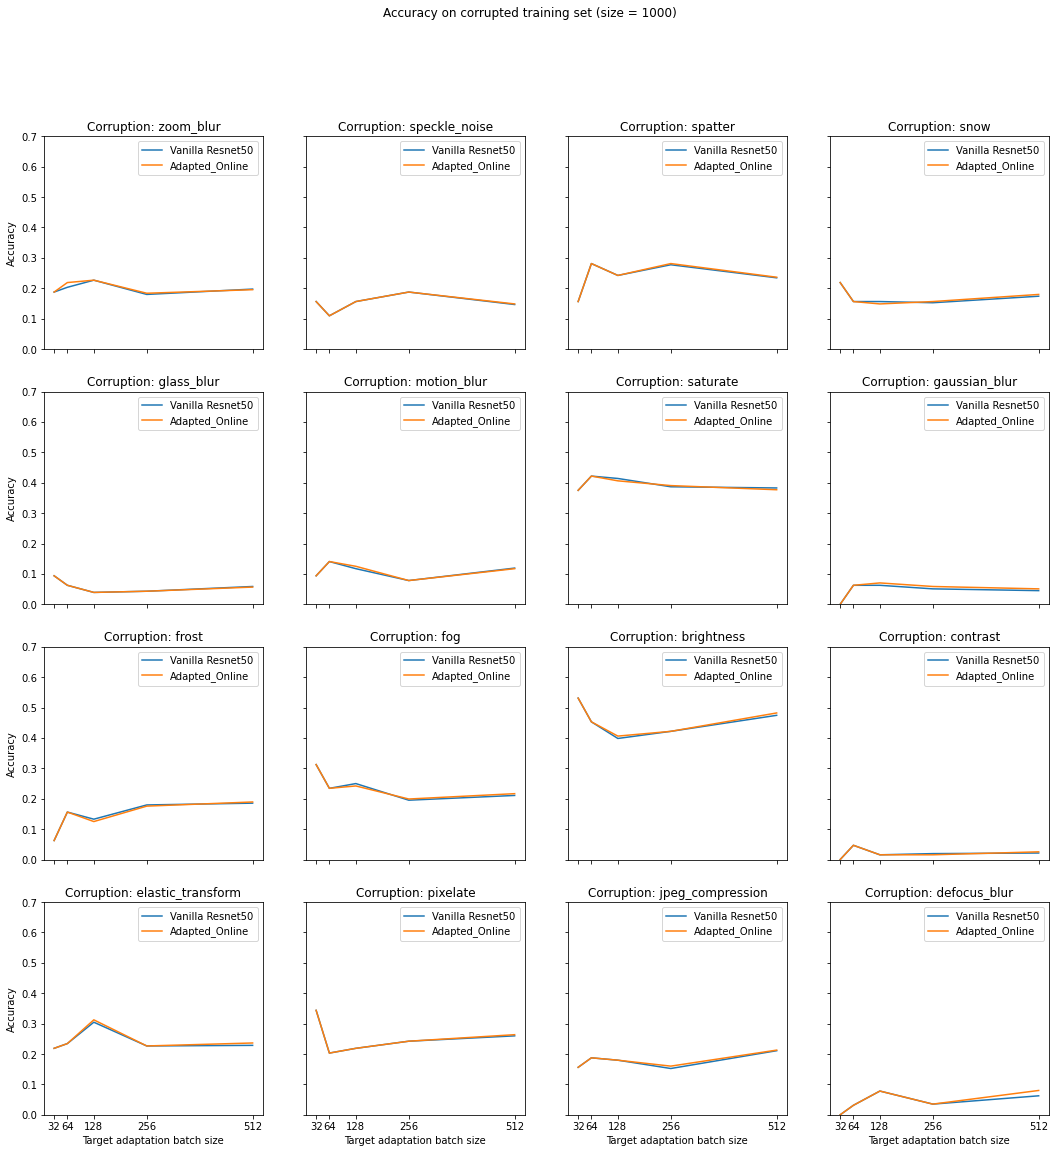

In [52]:
fig, ax = plt.subplots(4,4, figsize=(18, 18))
fig.suptitle('Accuracy on corrupted training set (size = 1000)')
for cor_ind in range(len(corruption)):
#     ax[cor_ind].plot(target_sizes, rpl_corrupt_val_acc[cor_ind][0])
#     ax[cor_ind].plot(target_sizes, rpl_corrupt_val_acc[cor_ind][1])
#     ax[cor_ind].plot(target_sizes, rpl_corrupt_val_acc[cor_ind][2])
#     ax[cor_ind].plot(target_sizes, rpl_corrupt_val_acc[cor_ind][3])
    ax[cor_ind//4][cor_ind%4].plot(target_sizes, baseline_train_acc[cor_ind][4], label = 'Vanilla Resnet50')
#     ax[cor_ind//4][cor_ind%4].plot(target_sizes, rpl_corrupt_val_acc[cor_ind][4], label='Adapted')
#     ax[cor_ind].plot(target_sizes, rpl_corrupt_train_acc[cor_ind][4], label='corrupted training(adapting) accuracy')
#     ax[cor_ind].plot(target_sizes, rpl_ref_acc[cor_ind][4])
    ax[cor_ind//4][cor_ind%4].plot(target_sizes, rpl_corrupt_train_acc[cor_ind][4], label = 'Adapted_Online')
    
    ax[cor_ind//4][cor_ind%4].legend()
    ax[cor_ind//4][cor_ind%4].set_title('Corruption: '+corruption[cor_ind])
    ax[cor_ind//4][cor_ind%4].set_xticks(target_sizes)
    ax[cor_ind//4][cor_ind%4].set_ylim([0, 0.7])


    
for a in ax.flat:
    a.set(xlabel='Target adaptation batch size', ylabel='Accuracy')
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
for a in ax.flat:
    a.label_outer()

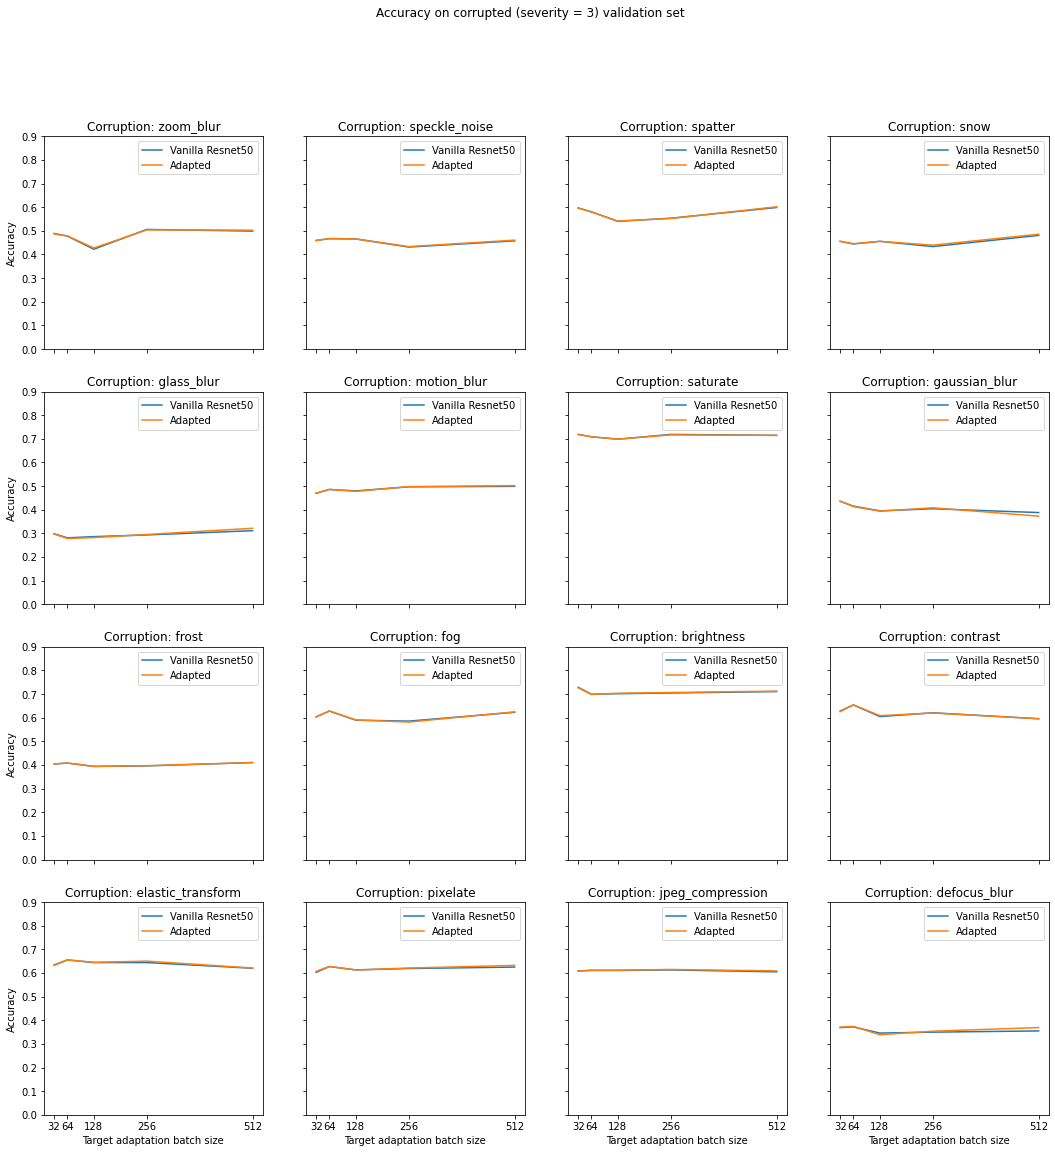

In [53]:
fig, ax = plt.subplots(4,4, figsize=(18, 18))
fig.suptitle('Accuracy on corrupted (severity = 3) validation set')
for cor_ind in range(len(corruption)):
#     ax[cor_ind].plot(target_sizes, rpl_corrupt_val_acc[cor_ind][0])
#     ax[cor_ind].plot(target_sizes, rpl_corrupt_val_acc[cor_ind][1])
#     ax[cor_ind].plot(target_sizes, rpl_corrupt_val_acc[cor_ind][2])
#     ax[cor_ind].plot(target_sizes, rpl_corrupt_val_acc[cor_ind][3])
    ax[cor_ind//4][cor_ind%4].plot(target_sizes, baseline_val_acc[cor_ind][2], label = 'Vanilla Resnet50')
    ax[cor_ind//4][cor_ind%4].plot(target_sizes, rpl_corrupt_val_acc[cor_ind][2], label='Adapted')
#     ax[cor_ind].plot(target_sizes, rpl_corrupt_train_acc[cor_ind][4], label='corrupted training(adapting) accuracy')
#     ax[cor_ind].plot(target_sizes, rpl_ref_acc[cor_ind][4])
#     ax[cor_ind//4][cor_ind%4].plot(target_sizes, rpl_corrupt_train_acc[cor_ind][2], label = 'Adapted_Online')
    
    ax[cor_ind//4][cor_ind%4].legend()
    ax[cor_ind//4][cor_ind%4].set_title('Corruption: '+corruption[cor_ind])
    ax[cor_ind//4][cor_ind%4].set_xticks(target_sizes)
    ax[cor_ind//4][cor_ind%4].set_ylim([0, 0.9])


    
for a in ax.flat:
    a.set(xlabel='Target adaptation batch size', ylabel='Accuracy')
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
for a in ax.flat:
    a.label_outer()

In [25]:
ref_dataset_sizes

{'val': 1000, 'test': 1000}

In [26]:
len(ref_dataloaders['val'])


391

In [44]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
model.eval()

Using cache found in /home/zw2774/.cache/torch/hub/pytorch_vision_v0.10.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [29]:
zoom_blur_loader = corrupted_dataloaders[0]['train']

In [56]:
corrects = 0
for images, labels in zoom_blur_loader:
    outputs = model(images)
    _, preds = torch.max(outputs, 1)
    corrects += torch.sum(preds == labels.data)
total_accuracy = corrects/corrupted_dataset_sizes[0]['train']

In [55]:
torch.sum(preds == y.data)

tensor(15)